In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import lang2vec.lang2vec as l2v
import seaborn as sns

import seaborn as sns

# For plots with LaTeX, might give issues depending on your local LaTeX installation
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{bm}',
    'font.family': 'serif',
})

In [2]:
df = pd.read_csv("raw_results/distilbert-base-multilingual-cased__opus100.csv")

In [3]:
lang2vec_mapping = {
    "af": "afr",
    "ar": "arb",
    "bg": "bul",
    "ca": "cat",
    "cs": "ces",
    "da": "dan",
    "de": "deu",
    "el": "ell",
    "es": "spa",
    "fa": "fas",
    "fi": "fin",
    "fr": "fra",
    "he": "heb",
    "hi": "hin",
    "hu": "hun",
    "it": "ita",
    "ja": "jpn",
    "ko": "kor",
    "lt": "lit",
    "lv": "lav",
    "no": "nob",
    "pl": "pol",
    "pt": "por",
    "ro": "ron",
    "ru": "rus",
    "sk": "slk",
    "sl": "slv",
    "sv": "swe",
    "ta": "tam",
    "th": "tha",
    "tr": "tur",
    "uk": "ukr",
    "vi": "vie",
    "zh": "cmn"
}

In [4]:
# Renaming for convenience
ALIGNERS = ["fastalign", "awesome", "dico"]

for aligner in ALIGNERS:
    df["method"] = df["method"].replace(f"freeze_realign_unfreeze_{aligner}", f"before_partial_freeze_front_{aligner}")
    df["method"] = df["method"].replace(f"freeze_realign_unfreeze_last_half_{aligner}", f"before_partial_freeze_back_{aligner}")

In [5]:
LANGUAGES = list(filter(lambda x: x not in ["same", "avg"], map(lambda x: x[len("final_eval_"):-len("_accuracy")] , filter(lambda x: x.startswith("final_eval_") and x.endswith("_accuracy"), df.columns))))

In [6]:
df[f"final_eval_ar_accuracy"]

0     0.640894
1     0.634467
2     0.637230
3     0.637665
4     0.646639
        ...   
90    0.647415
91    0.653780
92    0.652911
93    0.656451
94    0.655240
Name: final_eval_ar_accuracy, Length: 95, dtype: float64

In [7]:
def plot_freezing_impact_by_language(
    df,
    task="udpos",
    model="distilbert-base-multilingual-cased",
    method="before",
    aligner="dico",
    languages=LANGUAGES,
    figsize=(12, 7),
    distances=None,
    fig_name=None,
    heatmap=False,
    with_back=True
):
    method_delta = []
    front_delta = []
    back_delta = []

    distances = distances or []
    lang2vec_distances = {key: [] for key in distances}

    baseline_stddev = []
    method_stddev = []
    front_stddev = []
    back_stddev = []

    subdf = df[(df.task == task) & (df.model == model)]
    print(len(subdf))
    baseline_df = subdf[subdf.method == "baseline"]
    method_df = subdf[subdf.method == f"{method}_{aligner}"]
    front_df = subdf[subdf.method == f"{method}_partial_freeze_front_{aligner}"]
    back_df = subdf[subdf.method == f"{method}_partial_freeze_back_{aligner}"]
    print(len(baseline_df))
    print(len(method_df))
    print(len(front_df))
    print(len(back_df))

    for lang in languages:
        baseline_value = np.mean(baseline_df[f"final_eval_{lang}_accuracy"])
        method_value = np.mean(method_df[f"final_eval_{lang}_accuracy"])
        front_value = np.mean(front_df[f"final_eval_{lang}_accuracy"])
        back_value = np.mean(back_df[f"final_eval_{lang}_accuracy"])

        baseline_stddev.append(np.std(baseline_df[f"final_eval_{lang}_accuracy"]))
        method_stddev.append(np.std(method_df[f"final_eval_{lang}_accuracy"]))
        front_stddev.append(np.std(front_df[f"final_eval_{lang}_accuracy"]))
        back_stddev.append(np.std(back_df[f"final_eval_{lang}_accuracy"]))

        method_delta.append(method_value - baseline_value)
        front_delta.append(front_value - baseline_value)
        back_delta.append(back_value - baseline_value)

        for key in lang2vec_distances:
            lang2vec_distances[key].append(
                l2v.distance(key, "eng", lang2vec_mapping[lang])
            )

    method_delta = np.array(method_delta)
    front_delta = np.array(front_delta)
    back_delta = np.array(back_delta)

    baseline_stddev = np.array(baseline_stddev)
    method_stddev = np.array(method_stddev)
    front_stddev = np.array(front_stddev)
    back_stddev = np.array(back_stddev)

    ids = np.argsort(method_delta)[::-1]

    method_delta = method_delta[ids]
    front_delta = front_delta[ids]
    back_delta = back_delta[ids]

    baseline_stddev = baseline_stddev[ids]
    method_stddev = method_stddev[ids]
    front_stddev = front_stddev[ids]
    back_stddev = back_stddev[ids]

    for key in lang2vec_distances:
        lang2vec_distances[key] = np.array(lang2vec_distances[key])[ids]

    if heatmap:
        # sns.set(rc={"figure.figsize": figsize})
        plt.figure(figsize=figsize)
        values = np.zeros((3, method_delta.shape[0]))
        values[0] = method_delta
        values[1] = front_delta
        values[2] = back_delta

        ax = sns.heatmap(
            values,
            center=0.0,
            xticklabels=[languages[i] for i in ids],
            yticklabels=["None", "Front", "Back"],
            cmap="Spectral",
            # cmap=LinearSegmentedColormap.from_list("custom", ["#F8A111", "#1168F8"]),
            cbar_kws={"pad": 0.02}
        )
        ax.set_xlabel(r"\textbf{Languages}", fontsize=16, labelpad=10)
        ax.set_ylabel(r"\textbf{Freezing Strategy}", fontsize=16, labelpad=10)

        cbar = plt.gcf().axes[-1] 
        cbar.set_ylabel(r'\textbf{Average $\bm{\Delta}$ increase in accuracy}', fontsize=14, rotation=270, labelpad=20)
        cbar.tick_params(labelsize=12) 

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        
    else:
        fig, ax = plt.subplots(figsize=figsize)

        ax.bar(
            np.arange(len(languages)) - 0.2,
            np.zeros(np.arange(len(languages)).shape),
            align="edge",
            width=-0.2,
            yerr=baseline_stddev,
            capsize=2.0,
            # label="Baseline"
        )
        ax.bar(
            np.arange(len(languages)),
            method_delta,
            align="edge",
            width=-0.2,
            label=r"\textbf{No freezing}",
            yerr=method_stddev,
            capsize=2.0,
            color="#F8A111"
        )
        ax.bar(
            np.arange(len(languages)),
            front_delta,
            align="edge",
            width=0.2,
            label=r"\textbf{Front freezing}" if with_back else r"\textbf{AlignFreeze}",
            yerr=front_stddev,
            capsize=2.0,
            color="#1168F8"
        )
        if with_back:
            ax.bar(
                np.arange(len(languages)) + 0.2,
                back_delta,
                align="edge",
                width=0.2,
                label=r"\textbf{Back freezing}",
                yerr=back_stddev,
                capsize=2.0,
                color="#F81168"
            )
    
        ax.set_xticks(np.arange(len(languages)))
        ax.set_xticklabels([languages[i] for i in ids])

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        
        ax.legend(fontsize=16)
        ax.set_axisbelow(True)
        # ax.grid(zorder=0)
    
        # ax2 = ax.twinx()
        # for key in lang2vec_distances:
        #     ax2.plot(np.arange(len(languages)), lang2vec_distances[key], label=key)
        # ax2.legend()
    
        plt.ylabel(r"\textbf{$\bm{\Delta}$ increase in accuracy}", fontsize=16)
        plt.xlabel(r"\textbf{Languages}", fontsize=16, labelpad=10)
        plt.legend()

    if fig_name:
        plt.savefig(fig_name, bbox_inches="tight")
    
    plt.show()

95
5
5
5
5


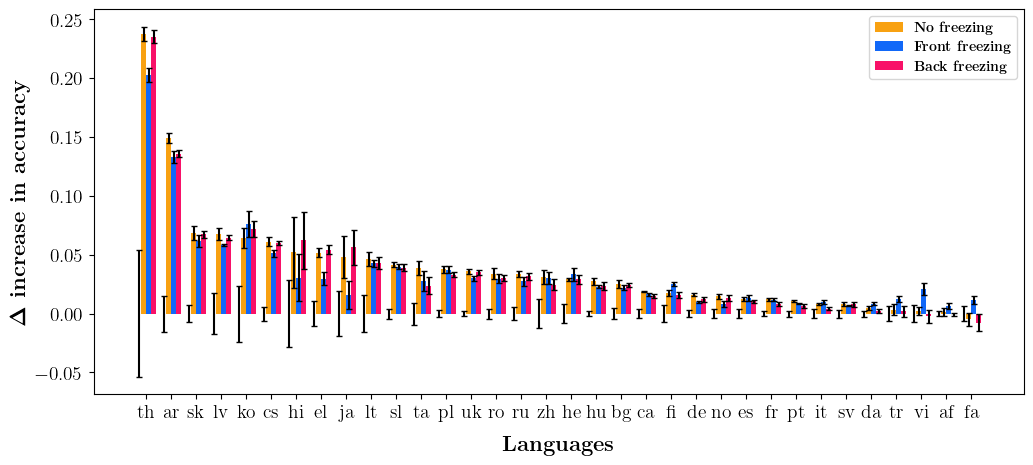

In [8]:
plot_freezing_impact_by_language(df, figsize=(12,5), distances=[], heatmap=False)

95
5
5
5
5


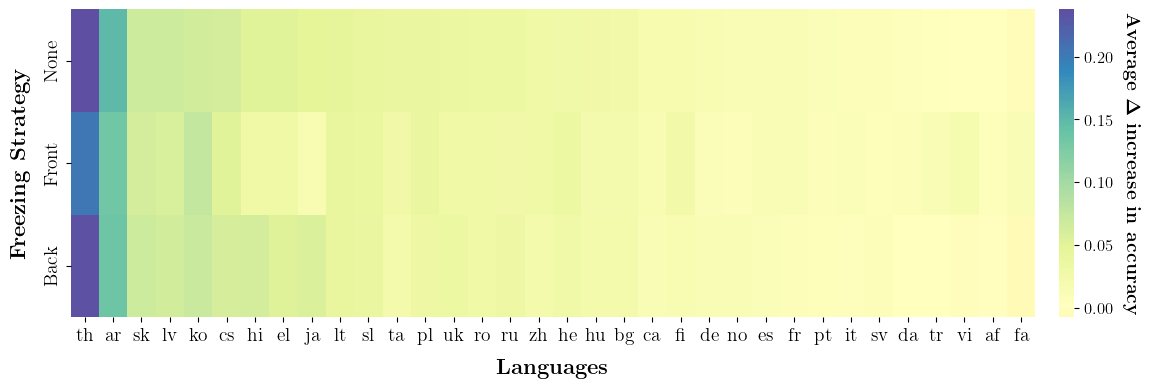

In [9]:
plot_freezing_impact_by_language(df, figsize=(15,4), distances=[], heatmap=True)

## Same for XNLI

In [10]:
xnli_df = pd.read_csv("raw_results/distilbert-base-multilingual-cased__xnli__opus100.csv")
# Renaming for convenience
ALIGNERS = ["fastalign", "awesome", "dico"]

for aligner in ALIGNERS:
    xnli_df["method"] = xnli_df["method"].replace(f"freeze_realign_unfreeze_{aligner}", f"before_partial_freeze_front_{aligner}")
    xnli_df["method"] = xnli_df["method"].replace(f"freeze_realign_unfreeze_last_half_{aligner}", f"before_partial_freeze_back_{aligner}")

In [11]:
XNLI_LANGUAGES = list(filter(lambda x: x not in ["same", "avg"], map(lambda x: x[len("final_eval_"):-len("_accuracy")] , filter(lambda x: x.startswith("final_eval_") and x.endswith("_accuracy"), xnli_df.columns))))

50
5
5
5
5


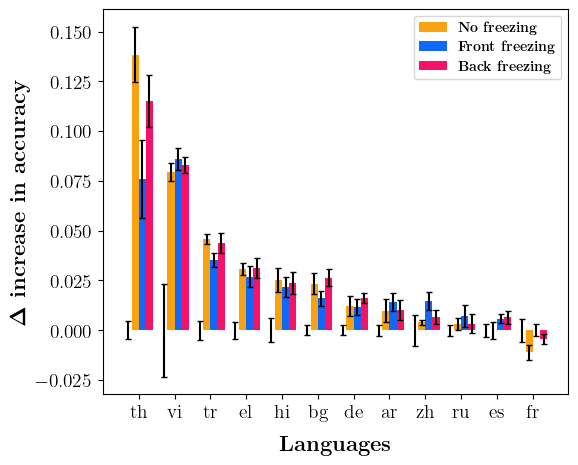

In [12]:
plot_freezing_impact_by_language(
    xnli_df,
    task="xnli",
    languages=["th", "vi", "tr", "el", "hi", "bg", "de", "ar", "zh", "ru", "es", "fr"],
    figsize=(6, 5),
    distances=[],
)

50
5
5
5
5


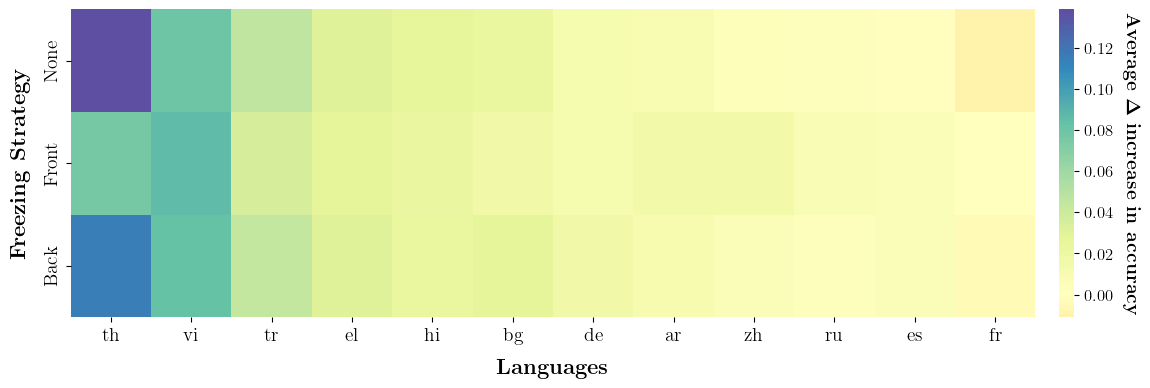

In [13]:
plot_freezing_impact_by_language(
    xnli_df,
    task="xnli",
    languages=["th", "vi", "tr", "el", "hi", "bg", "de", "ar", "zh", "ru", "es", "fr"],
    figsize=(15, 4),
    distances=[],
    heatmap=True
)


In [14]:
xnli_df.head()

,seed,model,task,method,finetuning_steps,realignment_steps,distinct_realignment_samples,repeated_realignment_samples,train_loss,realignment_loss,...,final_eval_hi_accuracy,final_eval_ru_accuracy,final_eval_sw_accuracy,final_eval_th_accuracy,final_eval_tr_accuracy,final_eval_ur_accuracy,final_eval_vi_accuracy,final_eval_zh_accuracy,final_eval_avg_accuracy,final_eval_same_accuracy
0,31,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.565891,0,...,0.566267,0.644511,NaN,0.500000,0.620758,NaN,0.657485,0.662076,0.636810,0.773852
1,42,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.176881,0,...,0.560279,0.641517,NaN,0.473453,0.609780,NaN,0.656487,0.648303,0.627229,0.778443
2,66,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.705611,0,...,0.557485,0.645509,NaN,0.465669,0.612375,NaN,0.657485,0.648703,0.626015,0.776647
3,23,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.548444,0,...,0.561876,0.652295,NaN,0.445908,0.610978,NaN,0.656287,0.650699,0.629375,0.776447
4,17,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.535980,0,...,0.568263,0.645509,NaN,0.466667,0.607186,NaN,0.650699,0.647106,0.627778,0.776248


### UDPOS with XLM-R

In [15]:
import wandb
import csv
import json

api = wandb.Api()

langs = ["same", "avg", "af", "ar", "bg", "ca", "cs", "da", "de", "el", "es", "fa", "fi", "fr", "he", "hi",
         "hu", "it", "ja", "ko", "lt", 'lv', 'no', 'pl', 'pt', 'ro', 'ru', 'sk', 'sl', 'sv', 'ta', 'th', 'tr', 'uk',
         'vi', 'zh']

In [16]:
def create_csv_from_wandb(output_file: str, columns, prefix="3nl_34langs", username="felixgaschi", langs=langs, workspace = "align_freeze"):
   
    
    project_names = [f"{prefix}_{method}" for method in [
        "baseline_udpos",
        *[
            f"{method}_{aligner}_udpos"
            for method in ["before", "during"]
            for aligner in ALIGNERS
        ],
        *[
            f"freeze_realign_unfreeze_{aligner}_udpos"
            for aligner in ALIGNERS
        ],
        *[
            f"freeze_realign_unfreeze_last_6_{aligner}_udpos"
            for aligner in ALIGNERS
        ]
    ]]

    with open(output_file, "w") as f:
        writer = csv.writer(f)
        writer.writerow(columns)

        for name in project_names:
            runs = api.runs(f"{workspace}/{name}")

            for run in runs:
                if run.user.username == username:  
                    new_row = []
                    config = json.loads(run.json_config)
                    for c in columns:
                        if c in ["seed", "model", "task", "method"]:
                            new_row.append(config[c]["value"])
                        else:
                            new_row.append(run.summary.get(c))
                    writer.writerow(new_row)


In [17]:
create_csv_from_wandb("raw_results/xlm-roberta-base__opus100.csv", list(df.columns))

In [18]:
xlm_df = pd.read_csv("raw_results/xlm-roberta-base__opus100.csv")

for aligner in ALIGNERS:
    xlm_df["method"] = xlm_df["method"].replace(f"freeze_realign_unfreeze_{aligner}", f"before_partial_freeze_front_{aligner}")
    xlm_df["method"] = xlm_df["method"].replace(f"freeze_realign_unfreeze_last_6_{aligner}", f"before_partial_freeze_back_{aligner}")

70
5
5
5
5


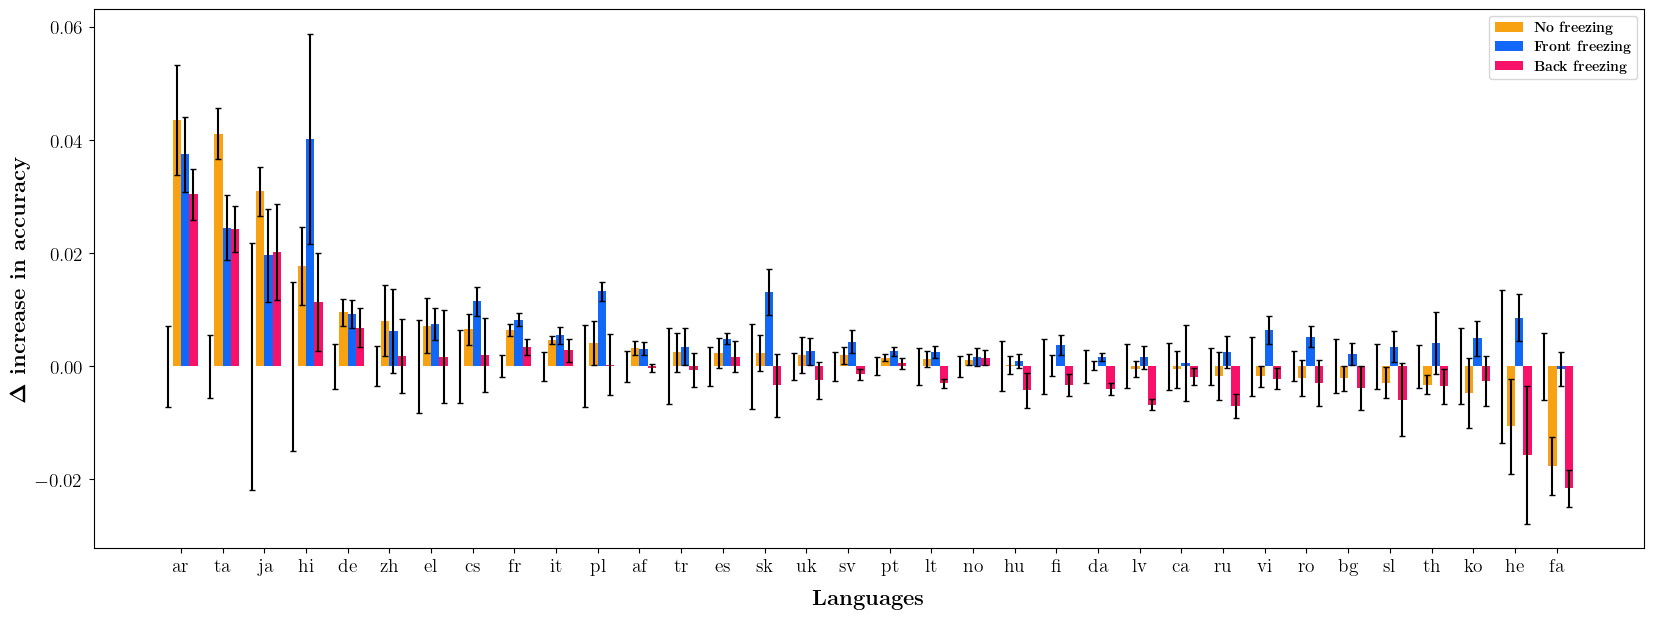

In [19]:
plot_freezing_impact_by_language(
    xlm_df,
    model="xlm-roberta-base",
    figsize=(20, 7),
    distances=[],
    fig_name="summary_plots/udpos-xlmr.pdf",
)

70
5
5
5
5


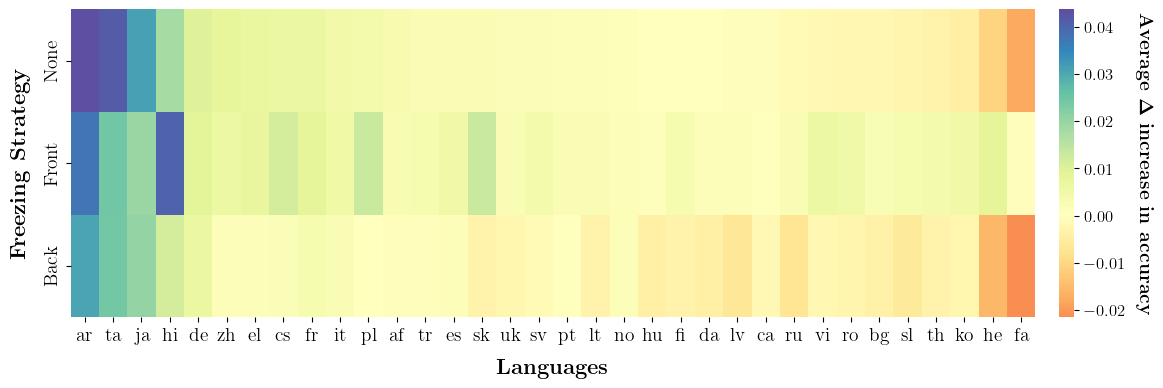

In [20]:
plot_freezing_impact_by_language(
    xlm_df,
    model="xlm-roberta-base",
    figsize=(15, 4),
    distances=[],
    fig_name="summary_plots/udpos-xlmr-heatmap.pdf",
    heatmap=True
)

70
5
5
5
5


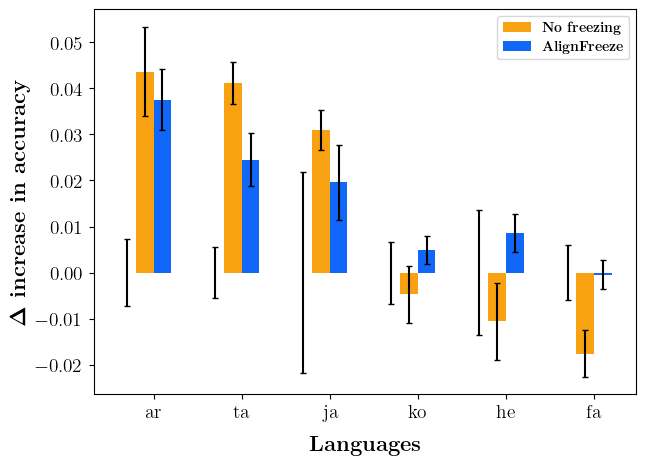

In [21]:
plot_freezing_impact_by_language(
    xlm_df,
    model="xlm-roberta-base",
    figsize=(7, 5),
    distances=[],
    languages=["ar", "ta", "ja", "ko", "he", "fa"],
    heatmap=False,
    fig_name="summary_plots/first_figure.pdf",
    with_back=False
)

## XNLI XLM-R

In [35]:
xnli_df_xlm = pd.read_csv("raw_results/xlm-roberta-base__xnli__opus100__aggregated_additional.csv")
# Renaming for convenience
ALIGNERS = ["fastalign", "awesome", "dico"]

for aligner in ALIGNERS:
    xnli_df_xlm["method"] = xnli_df_xlm["method"].replace(f"freeze_realign_unfreeze_{aligner}", f"before_partial_freeze_front_{aligner}")
    xnli_df_xlm["method"] = xnli_df_xlm["method"].replace(f"freeze_realign_unfreeze_last_half_{aligner}", f"before_partial_freeze_back_{aligner}")

In [36]:
xnli_df_xlm

,seed,model,task,method,finetuning_steps,realignment_steps,distinct_realignment_samples,repeated_realignment_samples,train_loss,realignment_loss,...,final_eval_es_accuracy,final_eval_fr_accuracy,final_eval_hi_accuracy,final_eval_ru_accuracy,final_eval_th_accuracy,final_eval_tr_accuracy,final_eval_vi_accuracy,final_eval_zh_accuracy,final_eval_avg_accuracy,final_eval_same_accuracy
0,31,xlm-roberta-base,xnli,before_dico,24544,24544,17678,392660,0.511318,0,...,0.774251,0.768663,0.692016,0.738723,0.707784,0.711577,0.734930,0.719960,0.733466,0.822555
1,42,xlm-roberta-base,xnli,before_dico,24544,24544,17678,392660,0.109313,0,...,0.767864,0.760679,0.681038,0.739721,0.703792,0.710180,0.730938,0.722954,0.729075,0.826148
2,66,xlm-roberta-base,xnli,before_dico,24544,24544,17678,392660,0.529204,0,...,0.772854,0.764671,0.681836,0.743713,0.699800,0.715968,0.729142,0.724950,0.731005,0.825549
3,23,xlm-roberta-base,xnli,before_dico,24544,24544,17678,392660,0.358857,0,...,0.772655,0.762675,0.691816,0.741916,0.705788,0.719760,0.736128,0.727545,0.733683,0.826547
4,17,xlm-roberta-base,xnli,before_dico,24544,24544,17678,392660,0.496255,0,...,0.775050,0.764471,0.687425,0.738523,0.703393,0.720359,0.735130,0.722754,0.733051,0.826747
5,31,xlm-roberta-base,xnli,before_partial_freeze_front_dico,24544,24544,17678,392660,0.484947,0,...,0.774052,0.766667,0.693014,0.738922,0.713174,0.717365,0.738922,0.720559,0.735279,0.828743
6,42,xlm-roberta-base,xnli,before_partial_freeze_front_dico,24544,24544,17678,392660,0.129737,0,...,0.777445,0.767066,0.681437,0.745509,0.705190,0.710379,0.734930,0.722156,0.733234,0.833733
7,66,xlm-roberta-base,xnli,before_partial_freeze_front_dico,24544,24544,17678,392660,0.519986,0,...,0.776248,0.768064,0.687226,0.743513,0.708583,0.719561,0.734331,0.725349,0.734930,0.834731
8,17,xlm-roberta-base,xnli,before_partial_freeze_back_dico,24544,24544,17678,392660,0.520344,0,...,0.768663,0.764271,0.692615,0.743313,0.702994,0.710978,0.737126,0.725349,0.732402,0.820559
9,23,xlm-roberta-base,xnli,before_partial_freeze_back_dico,24544,24544,17678,392660,0.336675,0,...,0.768862,0.755289,0.676846,0.737924,0.697206,0.714371,0.732335,0.718363,0.727994,0.821756


20
5
5
5
5


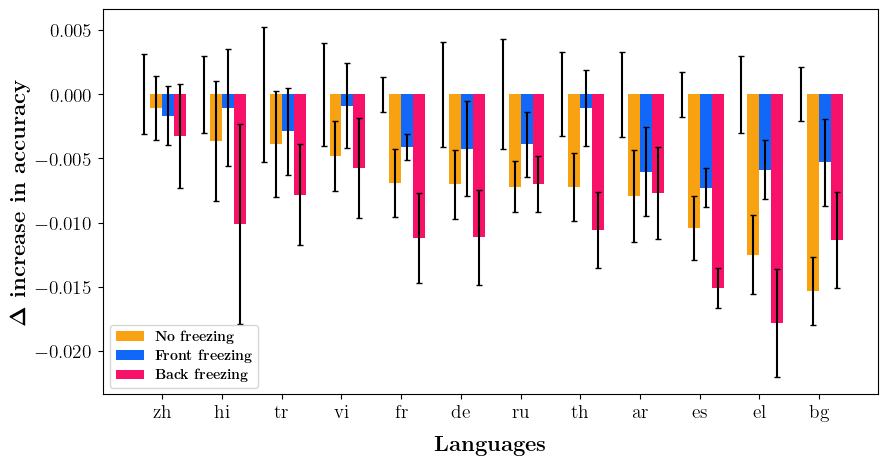

In [37]:
XNLI_XLM_LANGUAGES = list(
    filter(
        lambda x: x not in ["same", "avg"],
        map(
            lambda x: x[len("final_eval_") : -len("_accuracy")],
            filter(
                lambda x: x.startswith("final_eval_") and x.endswith("_accuracy"),
                xnli_df_xlm.columns,
            ),
        ),
    )
)

plot_freezing_impact_by_language(
    xnli_df_xlm,
    task="xnli",
    model="xlm-roberta-base",
    languages=XNLI_XLM_LANGUAGES,
    figsize=(10, 5),
    distances=[],
    fig_name="summary_plots/nli-xlmr.pdf"
)

20
5
5
5
5


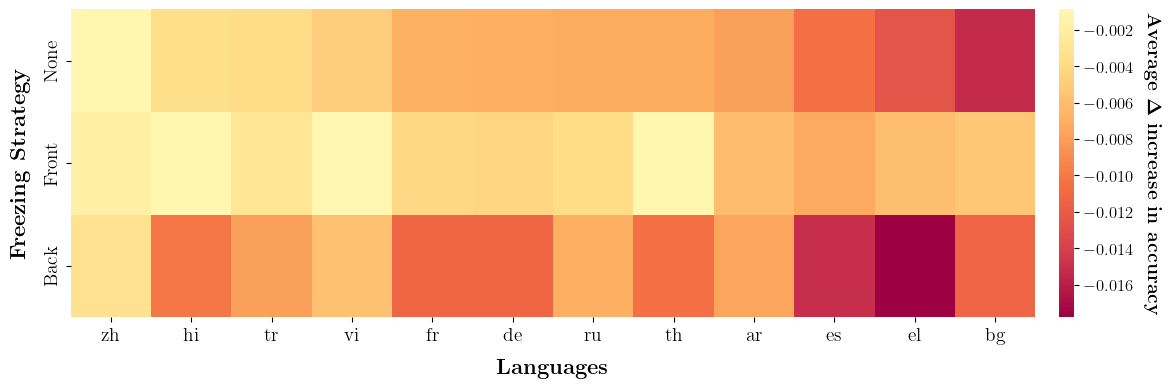

In [38]:
XNLI_XLM_LANGUAGES = list(
    filter(
        lambda x: x not in ["same", "avg"],
        map(
            lambda x: x[len("final_eval_") : -len("_accuracy")],
            filter(
                lambda x: x.startswith("final_eval_") and x.endswith("_accuracy"),
                xnli_df_xlm.columns,
            ),
        ),
    )
)

plot_freezing_impact_by_language(
    xnli_df_xlm,
    task="xnli",
    model="xlm-roberta-base",
    languages=XNLI_XLM_LANGUAGES,
    figsize=(15, 4),
    distances=[],
    fig_name="summary_plots/nli-xlmr-heatmap.pdf",
    heatmap=True
)

## mBERT udpos

In [26]:
updos_mbert_df = pd.read_csv("raw_results/bert-base-multilingual-cased__opus100.csv")
# Renaming for convenience
ALIGNERS = ["fastalign", "awesome", "dico"]

for aligner in ALIGNERS:
    updos_mbert_df["method"] = updos_mbert_df["method"].replace(f"freeze_realign_unfreeze_{aligner}", f"before_partial_freeze_front_{aligner}")
    updos_mbert_df["method"] = updos_mbert_df["method"].replace(f"freeze_realign_unfreeze_last_half_{aligner}", f"before_partial_freeze_back_{aligner}")

95
5
5
5
5


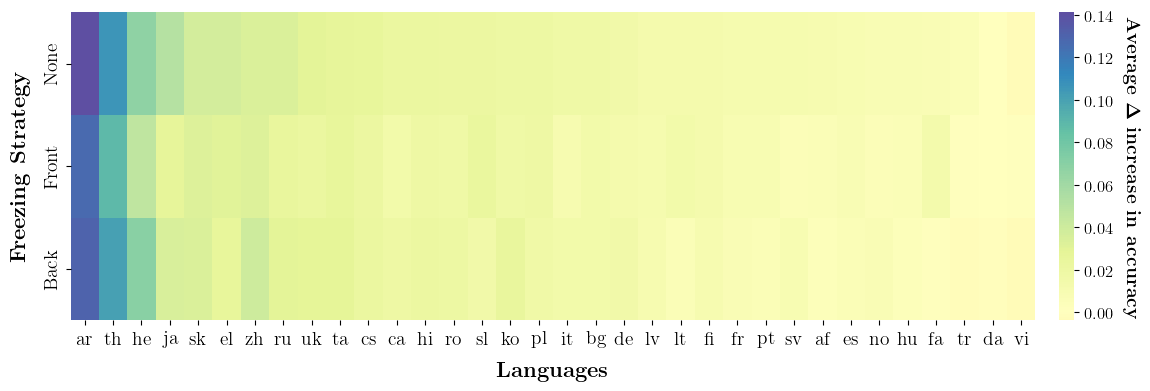

In [27]:
plot_freezing_impact_by_language(
    updos_mbert_df,
    task="udpos",
    model="bert-base-multilingual-cased",
    figsize=(15, 4),
    distances=[],
    fig_name="summary_plots/udpos-mbert-heatmap.pdf",
    heatmap=True
)

95
5
5
5
5


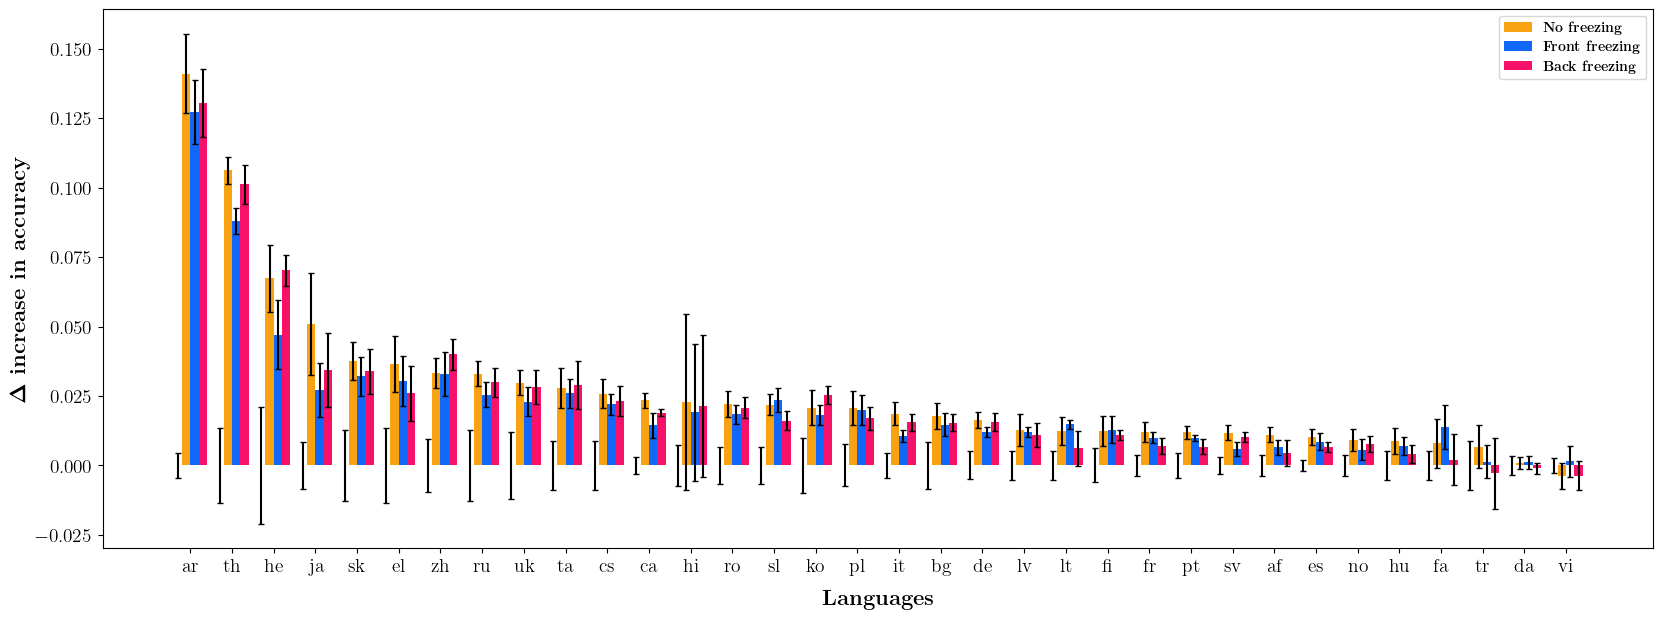

In [28]:
plot_freezing_impact_by_language(
    updos_mbert_df,
    model="bert-base-multilingual-cased",
    figsize=(20, 7),
    distances=[],
    fig_name="summary_plots/udpos-mbert.pdf",
)

## mBERT XNLI

In [29]:
xnli_mbert_df = pd.read_csv("raw_results/bert-base-multilingual-cased__xnli__opus100.csv")
# Renaming for convenience
ALIGNERS = ["fastalign", "awesome", "dico"]

for aligner in ALIGNERS:
    xnli_mbert_df["method"] = xnli_mbert_df["method"].replace(f"freeze_realign_unfreeze_{aligner}", f"before_partial_freeze_front_{aligner}")
    xnli_mbert_df["method"] = xnli_mbert_df["method"].replace(f"freeze_realign_unfreeze_last_half_{aligner}", f"before_partial_freeze_back_{aligner}")

20
5
5
5
5


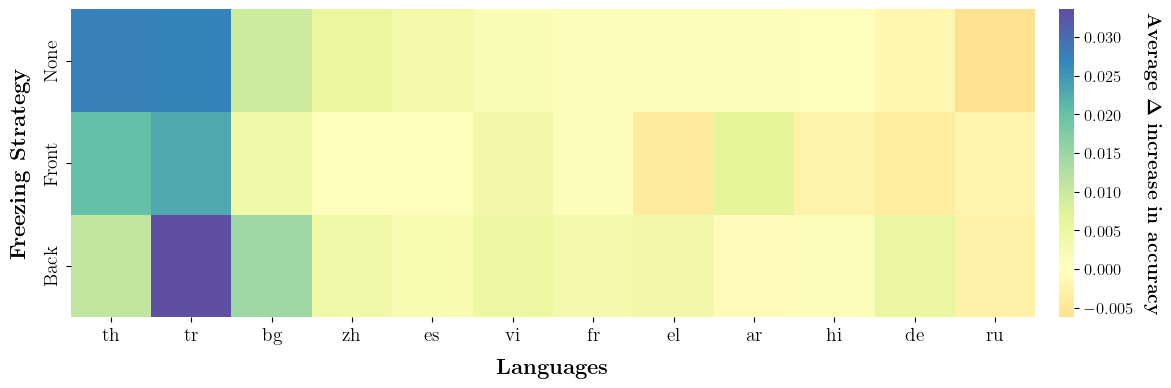

In [30]:
XNLI_MBERT_LANGUAGES = list(
    filter(
        lambda x: x not in ["same", "avg"],
        map(
            lambda x: x[len("final_eval_") : -len("_accuracy")],
            filter(
                lambda x: x.startswith("final_eval_") and x.endswith("_accuracy"),
                xnli_df_xlm.columns,
            ),
        ),
    )
)

plot_freezing_impact_by_language(
    xnli_mbert_df,
    task="xnli",
    model="bert-base-multilingual-cased",
    languages=XNLI_MBERT_LANGUAGES,
    figsize=(15, 4),
    distances=[],
    fig_name="summary_plots/nli-mbert-heatmap.pdf",
    heatmap=True
)

In [31]:
xnli_mbert_df.head()

,seed,model,task,method,finetuning_steps,realignment_steps,distinct_realignment_samples,repeated_realignment_samples,train_loss,realignment_loss,...,final_eval_es_accuracy,final_eval_fr_accuracy,final_eval_hi_accuracy,final_eval_ru_accuracy,final_eval_th_accuracy,final_eval_tr_accuracy,final_eval_vi_accuracy,final_eval_zh_accuracy,final_eval_avg_accuracy,final_eval_same_accuracy
0,31,bert-base-multilingual-cased,xnli,baseline,24544,0,0,0,0.447896,0,...,0.737525,0.736128,0.605788,0.685230,0.545709,0.617964,0.692615,0.697605,0.669311,0.807784
1,42,bert-base-multilingual-cased,xnli,baseline,24544,0,0,0,0.147365,0,...,0.730539,0.719361,0.604391,0.678443,0.554092,0.616567,0.684431,0.683034,0.664321,0.806786
2,66,bert-base-multilingual-cased,xnli,baseline,24544,0,0,0,0.785224,0,...,0.739122,0.732136,0.604790,0.674451,0.549900,0.617764,0.692814,0.692415,0.667914,0.808982
3,23,bert-base-multilingual-cased,xnli,baseline,24544,0,0,0,0.622327,0,...,0.736327,0.723952,0.577645,0.675449,0.493413,0.609581,0.684232,0.683034,0.654158,0.808184
4,17,bert-base-multilingual-cased,xnli,baseline,24544,0,0,0,0.653483,0,...,0.727545,0.728144,0.591417,0.677445,0.522754,0.606587,0.696607,0.687026,0.659365,0.809980


20
5
5
5
5


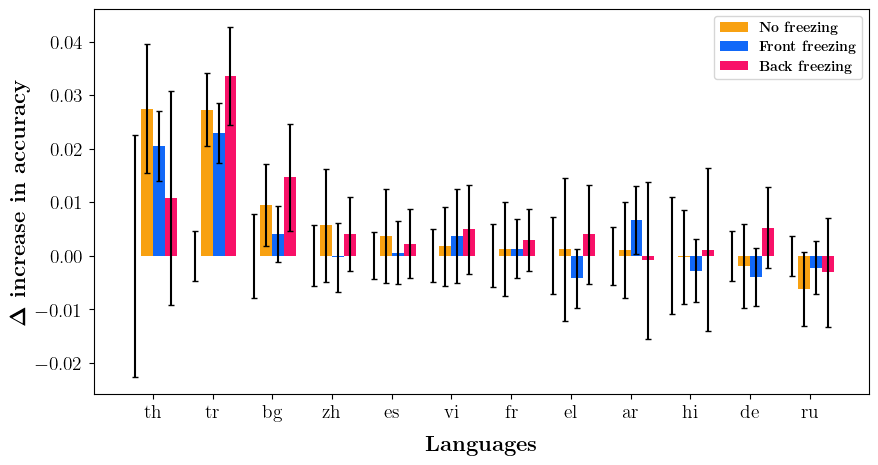

In [32]:
plot_freezing_impact_by_language(
    xnli_mbert_df,
    task="xnli",
    model="bert-base-multilingual-cased",
    languages=XNLI_MBERT_LANGUAGES,
    figsize=(10, 5),
    distances=[],
    fig_name="summary_plots/nli-mbert.pdf"
)

In [33]:
xnli_df.head()

,seed,model,task,method,finetuning_steps,realignment_steps,distinct_realignment_samples,repeated_realignment_samples,train_loss,realignment_loss,...,final_eval_hi_accuracy,final_eval_ru_accuracy,final_eval_sw_accuracy,final_eval_th_accuracy,final_eval_tr_accuracy,final_eval_ur_accuracy,final_eval_vi_accuracy,final_eval_zh_accuracy,final_eval_avg_accuracy,final_eval_same_accuracy
0,31,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.565891,0,...,0.566267,0.644511,NaN,0.500000,0.620758,NaN,0.657485,0.662076,0.636810,0.773852
1,42,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.176881,0,...,0.560279,0.641517,NaN,0.473453,0.609780,NaN,0.656487,0.648303,0.627229,0.778443
2,66,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.705611,0,...,0.557485,0.645509,NaN,0.465669,0.612375,NaN,0.657485,0.648703,0.626015,0.776647
3,23,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.548444,0,...,0.561876,0.652295,NaN,0.445908,0.610978,NaN,0.656287,0.650699,0.629375,0.776447
4,17,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.535980,0,...,0.568263,0.645509,NaN,0.466667,0.607186,NaN,0.650699,0.647106,0.627778,0.776248


In [34]:
df = xnli_mbert_df
subdf = df[(df.task == "xnli") & (df.model == "bert-base-multilingual-cased") & (df.method == "baseline")]
print(np.mean(subdf["final_eval_avg_accuracy"]))
print(np.std(subdf["final_eval_avg_accuracy"]))

0.6630139720558882
0.0056056837811041356
